# Recommendation System
### Using Matrix Factorization and Neural Collaborative Filtering

During this experiment we will be testing Matrix Factorization and Neural Collaborative Filtering for recommendation engines, using Movie Lens 20 Millions Dataset

References:
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages. DOI=<http://dx.doi.org/10.1145/2827872>

Exploratory Data Analysis, Model Definition, Training and Fine-Tunning described step by step on this Notebook

In [0]:
from IPython.display import clear_output
!pip install --upgrade tensorflow-gpu
clear_output()

In [0]:
#Downloads and extract Dataset to local, wait for download, i dont want to put a progress bar here sorry
#You can run this on google colab for get faster downloads speeds
import os
import zipfile
import requests

if(not os.path.exists("./Datasets/MoviLens20M.zip")):

  resp = requests.get("http://files.grouplens.org/datasets/movielens/ml-20m.zip")

  os.mkdir("./Datasets")

  with open("./Datasets/MoviLens20M.zip", "wb") as f:
    f.write(resp.content)

  with zipfile.ZipFile("./Datasets/MoviLens20M.zip", "r") as zip_ref:
    zip_ref.extractall("./Datasets")


In [0]:
#Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')
clear_output()

## Exploratory Data Analysis

Simple exploration without too much fancy graphs

In [4]:
#Loads Dataset, we only need ratings.csv and movies.csv files, we can drop timestamp and genres for now
ratings_df = pd.read_csv("./Datasets/ml-20m/ratings.csv").drop(["timestamp"], axis=1)
movies_df = pd.read_csv("./Datasets/ml-20m/movies.csv").drop(["genres"], axis=1)

ml_df = ratings_df.merge(movies_df, on="movieId")

ml_df = ml_df.reindex(columns=["userId", "movieId", "title", "rating"])
ml_df.head()

,userId,movieId,title,rating
0,1,2,Jumanji (1995),3.5
1,5,2,Jumanji (1995),3.0
2,13,2,Jumanji (1995),3.0
3,29,2,Jumanji (1995),3.0
4,34,2,Jumanji (1995),3.0


In [5]:
#Check info about the Dataset
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId     int64
movieId    int64
title      object
rating     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 762.9+ MB


In [6]:
#Check for NaNs
ml_df.isna().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

In [7]:
#List unique values of each column
n_users = ml_df["userId"].max()
n_movies = ml_df["movieId"].nunique()

print("Unique Users: " + str(n_users))
print("Unique Movies: " + str(n_movies))

Unique Users: 138493
Unique Movies: 26744


In [8]:
#Top movies with more rating count (dont confuse with more views or more rating score, but are correlated)
count = ml_df["title"].value_counts()
count[:15]

Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
Toy Story (1995)                             49695
Fugitive, The (1993)                         49581
Apollo 13 (1995)                             47777
Independence Day (a.k.a. ID4) (1996)         47048
Usual Suspects, The (1995)                   47006
Name: title, dtype: int64

## Preprocessing

In [9]:
#Encode ratings, now will encode the probability of relevance of the item for the user
#The negative sampling ratio under this setup is almost 2.5, but can be better have a setup of 5.0 ratio
ml_df["relevance"] = (ml_df["rating"] >= 5.0).astype(dtype=float)

#Set Ids as categorical data
ml_df["userId"] = ml_df["userId"].astype("category").cat.codes.values
ml_df["movieId"] = ml_df["movieId"].astype("category").cat.codes.values

ml_df.head()

,userId,movieId,title,rating,relevance
0,0,1,Jumanji (1995),3.5,0.0
1,4,1,Jumanji (1995),3.0,0.0
2,12,1,Jumanji (1995),3.0,0.0
3,28,1,Jumanji (1995),3.0,0.0
4,33,1,Jumanji (1995),3.0,0.0


In [0]:
#Redimension Target data.
users = ml_df["userId"].values
movies = ml_df["movieId"].values
relevance = ml_df["relevance"].values.reshape([-1, 1])

In [0]:
#Create Datasets for train, evaluation and testing, and a full version of the dataset
#Note: Value of shuffle buffer argument is crucial for get well distributed dataset slices
ml_ds = tf.data.Dataset.from_tensor_slices(({"userId":users, "movieId":movies}, relevance)).shuffle(200000)
full_ds = ml_ds
eval_ds = ml_ds.take(10000).batch(10000)
ml_ds = ml_ds.skip(10000)
test_ds = ml_ds.take(10000).batch(10000)
train_ds = ml_ds.skip(10000).shuffle(10000)

<Figure size 432x288 with 0 Axes>

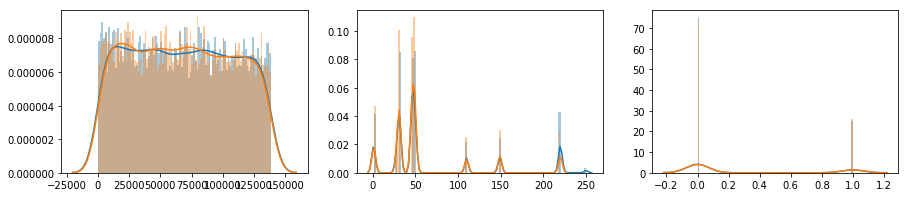

In [12]:
#Check distributions of dataset slices, if both dist are close, we can inffer the distribution between the three datasets comes from the same distribution
#Avoid calculate train dataset dist due to computational resources required for preprocess 20 Millions datapoints.
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
sns.distplot([sample["userId"] for sample, relevance in test_ds], bins=100)
sns.distplot([sample["userId"] for sample, relevance in eval_ds], bins=100)

plt.subplot(1, 3, 2)
sns.distplot([sample["movieId"] for sample, relevance in test_ds], bins=100)
sns.distplot([sample["movieId"] for sample, relevance in eval_ds], bins=100)

plt.subplot(1, 3, 3)
sns.distplot([relevance for sample, relevance in test_ds], bins=100)
sns.distplot([relevance for sample, relevance in eval_ds], bins=100)

plt.show()

# Generalized Matrix Factorization

On this section we will implement the GMF described [on this paper](https://arxiv.org/pdf/1708.05031.pdf).  This generalization introduces non-linearities and change dot product by element-wise product. Check the paper on GMF section for more details. I will write this model with reusability on mind, so you will be able to pick this and use it on your implementations easily. I will create a repo for this implementation later.

In [0]:
class GeneralizedMatrixFactorizer(tf.keras.Model):
  """
  Generalized Matrix Factorization Model 

  Element-wise Product of Embeddings instead of Dot Product
  Non-Linear Activation Capability

  Args:
    alpha (int): Represent the first Embedding Layer Max Tokens Size, on movie recommendation examples, this can be the max number of users
    beta (int): Represent the second Embedding Layer Max Tokens Size, on movie recommendation examples, this can be the max number of movies
    emb_dim (int): Dimension of the latent space representation of both Embedding Layers
    alpha_key (str): alpha is an independent input to the model, alpha_key is the key name in the call() input dictionary assigned to alpha, default="alpha"
    beta_key (str): beta is an independent input to the model, beta_key is the key name in the call() input dictionary assigned to beta, default="beta"

  """

  def __init__(self, alpha, beta, emb_dim, output_dim, alpha_key="alpha", beta_key="beta"):
    super(GeneralizedMatrixFactorizer, self).__init__()

    self.alpha_key = alpha_key
    self.beta_key = beta_key

    self.alpha_emb = tf.keras.layers.Embedding(alpha, emb_dim)
    self.alpha_bias = tf.keras.layers.Embedding(alpha, 1)

    self.beta_emb = tf.keras.layers.Embedding(beta, emb_dim)
    self.beta_bias = tf.keras.layers.Embedding(beta, 1)
    
    self.flat = tf.keras.layers.Flatten()
    self.mul = tf.keras.layers.Multiply()
    self.out = tf.keras.layers.Dense(output_dim, "sigmoid")

  def call(self, inputs):
    alpha_emb = self.alpha_emb(inputs[self.alpha_key])
    alpha_emb = self.flat(alpha_emb)
    alpha_bias = self.alpha_bias(inputs[self.alpha_key])
    alpha_bias = self.flat(alpha_bias)

    beta_emb = self.beta_emb(inputs[self.beta_key])
    beta_emb = self.flat(beta_emb)
    beta_bias = self.beta_bias(inputs[self.beta_key])
    beta_bias = self.flat(beta_bias)

    bias = tf.add(alpha_bias, beta_bias)
    X = self.mul([alpha_emb, beta_emb])
    X = tf.add(X, bias)
    X = self.out(X)
    return X

In [0]:
#Hyper-parameters
emb_dim = 32
lr = 0.002
epochs = 10
batch_size = 8192

In [0]:
#Instantiation
gmf = GeneralizedMatrixFactorizer(n_users, n_movies, emb_dim, output_dim=1, alpha_key="userId", beta_key="movieId")
gmf.compile(tf.keras.optimizers.Adam(lr), tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy()])

In [16]:
#Fitting
gmf.fit(train_ds.batch(batch_size), epochs=epochs, validation_data=eval_ds)

Epoch 1/10
2439/2439 [==============================] - 255s 105ms/step - loss: 0.3337 - binary_accuracy: 0.8582 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/10
2439/2439 [==============================] - 264s 108ms/step - loss: 0.3016 - binary_accuracy: 0.8699 - val_loss: 0.4392 - val_binary_accuracy: 0.7951
Epoch 3/10
2439/2439 [==============================] - 263s 108ms/step - loss: 0.2761 - binary_accuracy: 0.8817 - val_loss: 0.3715 - val_binary_accuracy: 0.8336
Epoch 4/10
2439/2439 [==============================] - 263s 108ms/step - loss: 0.2513 - binary_accuracy: 0.8932 - val_loss: 0.3287 - val_binary_accuracy: 0.8541
Epoch 5/10
2439/2439 [==============================] - 262s 107ms/step - loss: 0.2288 - binary_accuracy: 0.9039 - val_loss: 0.2702 - val_binary_accuracy: 0.8850
Epoch 6/10
2439/2439 [==============================] - 264s 108ms/step - loss: 0.2124 - binary_accuracy: 0.9119 - val_loss: 0.2417 - val_binary_accuracy: 0.9021
Epoch 7/10
2439/2439

In [17]:
gmf.evaluate(test_ds)

1/1 [==============================] - 0s 310ms/step - loss: 0.1880 - binary_accuracy: 0.9318


[0.18803000450134277, 0.9318]

## Naural Matrix Factorization

Lets implement this hybrid architecture, described [here](https://arxiv.org/pdf/1708.05031.pdf). It features a parallel architecture between a generalization of classic Matrix Factorization called Generalized Matrix Factorization, and Deep Feedforward Network, both of them feeded by its own Embeddings pair for users and items. [Check the paper](https://arxiv.org/pdf/1708.05031.pdf) for more details.

In [0]:
class DenseBlock(tf.keras.layers.Layer):
  """
  Dense Block Unit

  Features Batch Normalization, Dropout and Dense layers, in that order
  Created for convenient building of Deep Feedforward Networks

  Args:
    units (int): Number of units on Dense Layer
    dropout (float): % of inputs to drop from Batch Normalization Layer
    l2 (float): Strenght of L2 regularization on Dense Layer

  """

  def __init__(self, units, dropout=0.1, l2=0.001):
    super(DenseBlock, self).__init__()

    self.bn = tf.keras.layers.BatchNormalization()
    self.drop = tf.keras.layers.Dropout(dropout)
    self.dense = tf.keras.layers.Dense(units, 
                                       "relu",
                                       kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2),
                                       kernel_constraint=tf.keras.constraints.UnitNorm())
    
  def call(self, inputs):
    X = self.bn(inputs)
    X = self.drop(X)
    X = self.dense(X)
    return X

In [0]:
class DeepFeedForward(tf.keras.Model):
  """
  Multi-Layer Perceptron
  """

  def __init__(self, layers, dropout=0.1, l2=0.001):
    super(DeepFeedForward, self).__init__()

    self.block_list = list()
    for layer in layers:
      self.block_list.append(DenseBlock(layer, dropout, l2))
    
  def call(self, inputs):
    X = inputs

    for layer in self.dense_list:
      X = layer(X)

In [0]:
class NeuMF(tf.keras.Model):
  """Neural Matrix Factorizer"""

  def __init__(self):
    super(NeuMF, self).__init__()